In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from metpy.calc import relative_humidity_from_dewpoint, mixing_ratio_from_relative_humidity
from metpy.units import units
from wrf import wetbulb, enable_xarray

import sys
sys.path.append('../../') # lets us import ptype package from the subdir

import sounding_utils
from importlib import reload

from functools import partial

#import ptype.

## Select forecast hour:

In [2]:
hour = '0000'

In [3]:
rap = xr.open_mfdataset(f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/{hour}/*.nc", concat_dim='time', combine='nested')
rap.attrs['nwp'] = 'rap'


In [8]:
from dataclasses import dataclass, field

In [9]:
@dataclass
class LineSpec():
    ds: xr.Dataset
    model: str
    ptype: str
    profile_var: str
    color: str
    marker: str
    lstyle: str = None
    median: bool = False
    prob: float = 0.0
    quantiles: list[float] = field(default_factory=list)
    optionalmask: xr.DataArray = None

In [29]:
def plot_linespec(fig, ax, **kwargs):
    LSTYLE = {'dpt_h': 'dashed',
              'wbulb': 'dotted',
              't_h': 'solid'}
    ##################### filtering #######################
    if model == 'nwp': 
        predtype = 'c' + ptype
    elif model == 'ML':
        predtype = "ML_c" + ptype
    else:
        raise ValueError('invalid LineSpec model must be str of ML or nwp')
    
    subset = ds.where((
                      (ds['crain'] == 1) | 
                      (ds['csnow'] == 1) | 
                      (ds['cicep'] == 1) | 
                      (ds['cfrzr'] == 1)
    ))
    subset = subset.where(ds["predtype"] == 1)
    if prob: 
        subset = subset.where(ds["ML_" + ptype] > prob)
    if optionalMask:
        subset = subset.where(optionalMask)
    
    #################### plotting ############################
    if median:
        profile = subset[profile_var].median(dim=('x','y','time'))
    else:
        profile = subset[profile_var].mean(dim=('x','y','time'))
    
    num_obs = subset[profile_var].count(dim=('x','y','time')).values[0]
    frac_above_zero = frac_abv_zero(subset, profile_var, num_obs)
    
    y = ds.heightAboveGround.values

    if not lstyle:
        lstyle = LSTYLE[profile_var]
    
    line, = ax.plot(profile, y, color, marker=marker, linestyle=lstyle)
    
    line.set_label((
                    f"{'' if 'ML' in predtype else subset.attrs['nwp'] + '_'}{predtype}"
                    f"{'>' + str(prob) if ('ML' in predtype) and (prob >0.0) else ''}"
                    f" {x_col}\nnum obs: {num_obs}\nFrac above 0: {frac_above_zero:.2f}"
                  ))
    ##################### quantiles ###########################
    quantiles = np.array(quantiles)
    if quantiles:
        q_vals = (subset[profile_var]
                  .chunk(dict(time=-1))
                  .quantile(
                      np.concatenate((quantiles, 1 - quantiles)),
                      dim=('x','y','time'))
                  )
        num_qs = len(quantiles)
        for i in range(num_qs):
            ax.fill_betweenx(y, 
                             q_vals[i], 
                             q_vals[i+num_qs], 
                             alpha=0.1, 
                             color=c)
    return fig, ax, line
    
def plot_specs(linespecs):
    fig,ax = skewCompositeFigAx()
    for spec in linespecs:
        fig, ax = plot_linespec(fig,ax,**spec.__dict__)
    return fig, ax

In [4]:
hrrr = xr.open_mfdataset(f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/hrrr/20220223/{hour}/*.nc", concat_dim='time', combine='nested')
hrrr.attrs['nwp'] = 'hrrr'


In [5]:
gfs = xr.open_mfdataset(f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/gfs/20220223/{hour}/*.nc", concat_dim='time', combine='nested')
gfs.attrs['nwp'] = 'gfs'


In [6]:
datasets = [gfs, hrrr, rap]

**Recall our calibration plots:**

![alt text](soundings_files/MLCalibration.png "Calibration of ML model")

In [7]:
lat_max = min([ds.latitude.max() for ds in datasets])
lat_min = max([ds.latitude.min() for ds in datasets])
lon_max = min([ds.longitude.max() for ds in datasets])
lon_min = max([ds.longitude.min() for ds in datasets])

In [8]:
def filter_latlon(ds, lat_max, lat_min, lon_max, lon_min):
    mask = (
            (ds.latitude <= lat_max) &
            (ds.latitude >= lat_min) &
            (ds.longitude <= lon_max) &
            (ds.longitude >= lat_min)
           )
    return ds.where(mask)

In [9]:
datasets_filtered = [filter_latlon(ds,lat_max, lat_min, lon_max, lon_min) for ds in datasets]

In [10]:
reload(sounding_utils)
plot_func = partial(sounding_utils.composites_multiplot,
                    datasets = datasets_filtered,
                    x_col = 't_h',
                    colors = ['blue', 'orange'],
                    markers = ['o','v', '+'],
                    plot_median=False)

(<Figure size 500x500 with 1 Axes>,
 <SkewXAxes: title={'center': 'Mean Interpolated t_h'}, xlabel='t_h', ylabel='Height above ground (m)'>)

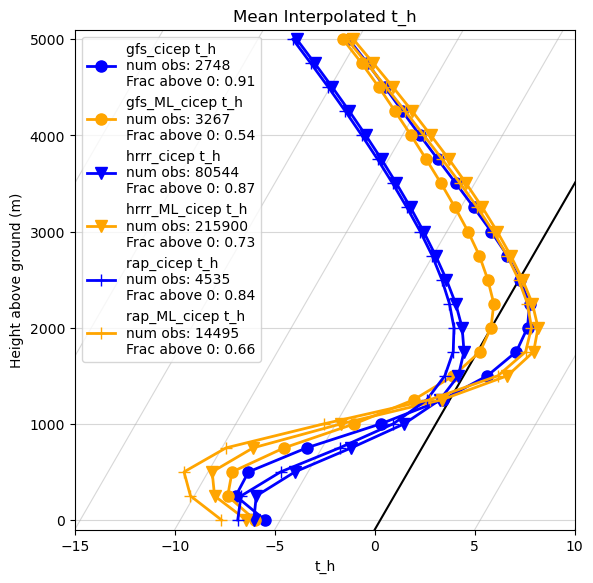

In [11]:
plot_func(cols=['cicep','ML_cicep'],xhighlim=10,xlowlim=-15)

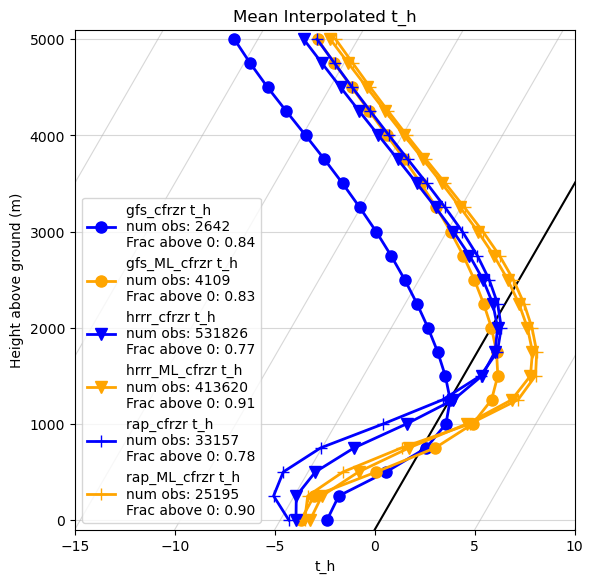

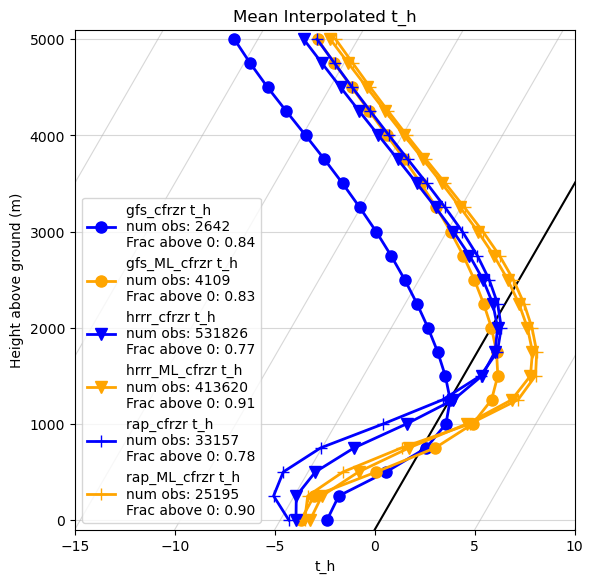

In [12]:
fig,ax=plot_func(cols=['cfrzr', 'ML_cfrzr'])
ax.set_xlim((-15,10))
fig

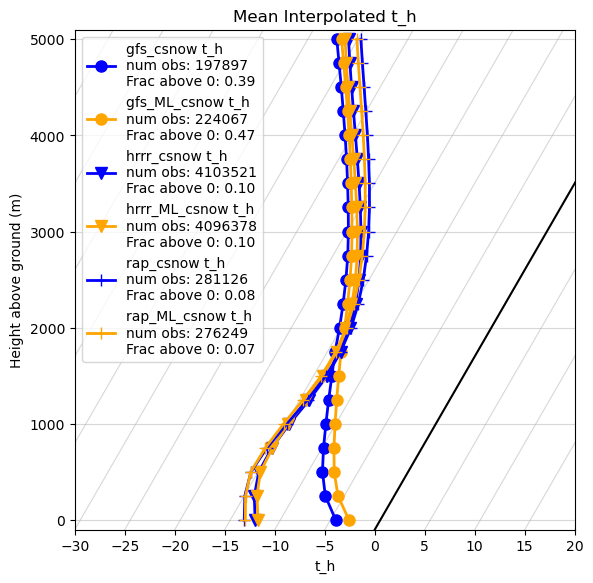

In [13]:
figS,axS = plot_func(cols=['csnow', 'ML_csnow'],xlowlim=-30)

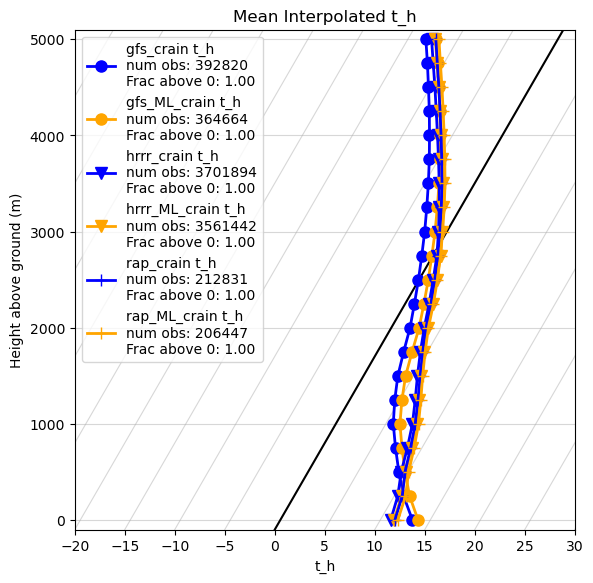

In [14]:

figR, axR = plot_func(cols=['crain', 'ML_crain'],xhighlim=30)

In [15]:
gfs

<xarray.Dataset>
Dimensions:            (time: 18, heightAboveGround: 21, y: 721, x: 1440,
                        isobaricInhPa: 33)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 0 250 500 ... 4500 4750 5000
  * isobaricInhPa      (isobaricInhPa) float32 1e+03 975.0 950.0 ... 3.0 2.0 1.0
    latitude           (y) float32 dask.array<chunksize=(721,), meta=np.ndarray>
    longitude          (x) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
  * time               (time) datetime64[ns] 2022-02-23 ... 2022-02-23
    step               (time) timedelta64[ns] 01:00:00 02:00:00 ... 18:00:00
    valid_time         (time) datetime64[ns] 2022-02-23T01:00:00 ... 2022-02-...
Dimensions without coordinates: y, x
Data variables: (12/29)
    t_h                (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 721, 1440), meta=np.ndarray>
    dpt_h              (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 721, 1440), meta=np.ndarray>
    u_h                (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 721, 1440), meta=np.ndarray>
    v_h                (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 721, 1440), meta=np.ndarray>
    isobaricInhPa_h    (time, heightAboveGround, y, x) float64 dask.array<chunksize=(1, 21, 721, 1440), meta=np.ndarray>
    t                  (time, isobaricInhPa, y, x) float32 dask.array<chunksize=(1, 33, 721, 1440), meta=np.ndarray>
    ...                 ...
    ML_snow            (time, y, x) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ML_csnow           (time, y, x) uint8 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ML_icep            (time, y, x) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ML_cicep           (time, y, x) uint8 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ML_frzr            (time, y, x) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    ML_cfrzr           (time, y, x) uint8 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    nwp:      gfs

In [16]:
hrrr

<xarray.Dataset>
Dimensions:                  (time: 18, heightAboveGround: 21, y: 1059,
                              x: 1799, isobaricInhPa: 40)
Coordinates:
  * heightAboveGround        (heightAboveGround) int64 0 250 500 ... 4750 5000
  * time                     (time) datetime64[ns] 2022-02-23 ... 2022-02-23
    step                     (time) timedelta64[ns] 01:00:00 ... 18:00:00
  * isobaricInhPa            (isobaricInhPa) float32 1.013e+03 1e+03 ... 50.0
    latitude                 (y, x) float32 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude                (y, x) float32 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    valid_time               (time) datetime64[ns] 2022-02-23T01:00:00 ... 20...
    y_projection_coordinate  (y) float32 dask.array<chunksize=(1059,), meta=np.ndarray>
    x_projection_coordinate  (x) float32 dask.array<chunksize=(1799,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/28)
    t_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 1059, 1799), meta=np.ndarray>
    dpt_h                    (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 1059, 1799), meta=np.ndarray>
    u_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 1059, 1799), meta=np.ndarray>
    v_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 1059, 1799), meta=np.ndarray>
    isobaricInhPa_h          (time, heightAboveGround, y, x) float64 dask.array<chunksize=(1, 21, 1059, 1799), meta=np.ndarray>
    t                        (time, isobaricInhPa, y, x) float32 dask.array<chunksize=(1, 40, 1059, 1799), meta=np.ndarray>
    ...                       ...
    ML_snow                  (time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    ML_csnow                 (time, y, x) uint8 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    ML_icep                  (time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    ML_cicep                 (time, y, x) uint8 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    ML_frzr                  (time, y, x) float32 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    ML_cfrzr                 (time, y, x) uint8 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    nwp:      hrrr

In [17]:
rap

<xarray.Dataset>
Dimensions:                  (time: 18, heightAboveGround: 21, y: 337, x: 451,
                              isobaricInhPa: 37)
Coordinates:
  * heightAboveGround        (heightAboveGround) int64 0 250 500 ... 4750 5000
  * time                     (time) datetime64[ns] 2022-02-23 ... 2022-02-23
    step                     (time) timedelta64[ns] 01:00:00 ... 18:00:00
  * isobaricInhPa            (isobaricInhPa) float32 1e+03 975.0 ... 125.0 100.0
    latitude                 (y, x) float32 dask.array<chunksize=(337, 451), meta=np.ndarray>
    longitude                (y, x) float32 dask.array<chunksize=(337, 451), meta=np.ndarray>
    valid_time               (time) datetime64[ns] 2022-02-23T01:00:00 ... 20...
    y_projection_coordinate  (y) float32 dask.array<chunksize=(337,), meta=np.ndarray>
    x_projection_coordinate  (x) float32 dask.array<chunksize=(451,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/29)
    t_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    dpt_h                    (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    u_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    v_h                      (time, heightAboveGround, y, x) float32 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    isobaricInhPa_h          (time, heightAboveGround, y, x) float64 dask.array<chunksize=(1, 21, 337, 451), meta=np.ndarray>
    t                        (time, isobaricInhPa, y, x) float32 dask.array<chunksize=(1, 37, 337, 451), meta=np.ndarray>
    ...                       ...
    ML_snow                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_csnow                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_icep                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_cicep                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_frzr                  (time, y, x) float32 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
    ML_cfrzr                 (time, y, x) uint8 dask.array<chunksize=(1, 337, 451), meta=np.ndarray>
Attributes:
    nwp:      rap